# Verificador Entregas
 
1. Poner una celda de markdown por carpeta (extraer nombre)
2. Luego copiar contenido de cada archivo .py en una celda de código.
3. Crea un cuaderno general con todas las entregas, y uno individual para retroalimentación del estudiante

## Uso

Copiar este cuaderno en la raiz de la carpeta donde se descomprimió la entrega en Aula Digital, luego ejecutarlo todo.


In [10]:
%reset -sf

extensions = [
    '.py',
    'otra_ext'
]

evaluacion = "Examen 1"
enunciado = '''
2. (35 puntos) En Colombia, toda persona natural cuyos ingresos, patrimonio, compras y consignaciones bancarias realizadas hasta diciembre 31 de 2021, superan unos topes establecidos por la DIAN, debe rendirle cuentas al gobierno sobre sus estados financieros por medio de la declaración de renta. Las condiciones y topes establecidos para determinar quién debe declarar son:
- Patrimonio a 31 de diciembre de 2021: superior a $163’386.000
- Ingresos brutos: iguales o superiores a $50’831.000
- Consumos con tarjeta de crédito, compras y consignaciones: superiores a $50’831.000
Cualquier tope que sobrepase, obliga a la persona natural a declarar renta en el año 2022.
Estas condiciones también aplican para menores de edad (a la fecha de presentación de la declaración), cuya declaración de renta debe ser firmada por sus padres o tutores.
La semana límite para presentar la declaración de renta está definida por los últimos dos dígitos del Número de Identificación Tributario (NIT), de acuerdo con la siguiente tabla:
Agosto	Septiembre	Octubre
Dígitos	Semana	Dígitos	Semana	Dígitos	Semana
01 al 08	2da	37 al 46	1ra	77 al 86	1ra
09 al 16	3ra	47 al 56	2da	87 al 96	2da
17 al 26	4ta	57 al 66	3ra	97 al 00	3ra
27 al 36	5ta	67 al 76	4ta		
Escriba un programa (script) en Python que reciba los siguientes datos:
•	NIT
•	Patrimonio
•	Ingresos brutos
•	Consumos con tarjeta de crédito, compras y consignaciones 
El programa deberá entregar si debe o no declarar renta en el año 2022, y en caso afirmativo, cuál es la semana y mes límite para presentar la declaración firmada.
'''

import os
from pathlib import Path

import tkinter as tk
from  tkinter import filedialog

root = tk.Tk()
root.withdraw()

''

## Procesar carpeta con archivos comprimidos o con carpetas descomprimidas

Requiere: 
- una carpeta con los .zip generados por Aula Digital
    - Con esta opción, descomprime los .zip y genera carpetas con consecutivos
o
- una carpeta con las subcarpetas de las evaluaciones.
    - Con esta opción, solo identifica las subcarpetas
    
El resultado es la lista ```basepaths```

In [11]:
rootpath = Path(filedialog.askdirectory())
# rootpath = Path(r"C:\Users\000092114\UPB\Fundamentos de Computacion 2022-20 - Profesores - Profesores\_notas\seg1\Test")
basepaths = []
content = rootpath.glob('*/')
contList = [Path(x) for x in content]
folders = [x for x in contList if x.is_dir()]
files = [x for x in contList if x.is_file() and x.suffix == ".zip"]
# print(folders)
# print(files)
generateNB = False
if folders == [] and files != []: # si no se ha descomprimido nada y hay .zips por descomprimir
    from zipfile import ZipFile
    grupo = 1
    # ahora se define el nombre de la carpeta con un consecutivo.
    for file in files:
        # Create a ZipFile Object and load sample.zip in it
        with ZipFile(str(file), 'r') as zipObj:
           # Extract all the contents of zip file in different directory
            zipObj.extractall(file.parent/str(grupo))
            generateNB = True
        basepaths.append(file.parent/str(grupo))
        grupo += 1
elif folders != []:
    basepaths = folders
    
print(basepaths)

[WindowsPath('C:/Users/000092114/UPB/Fundamentos de Computacion 2022-20 - Profesores - Profesores/_notas/examen1/1')]


## Procesar los archivos

In [12]:
pathList,nameList,scriptList = list(),list(),list()
for basepath in basepaths:
    for entry in os.listdir(basepath):
        entry = Path(entry)
        if str(entry).endswith("_assignsubmission_file_"):
            #agregue el path de la carpeta a la lista de paths
            pathList.append(basepath/entry)
            #agregue el nombre a la lista de nombres (extraido del nombre de la entrega)
            nameList.append(str(entry).split("_")[0])
            #recoja todos los archivos de cada entrega
            p = pathList[-1].glob("**/*")
            #solo guarde los que estén en la lista de extensiones (para evitar que coja los cuadernos)
            scriptList.append([x for x in p if x.is_file() and x.suffix in extensions])
    
print(scriptList)
    # leer el contenido del archivo como texto
    #print(scriptList[-1][-1].read_text())

[[WindowsPath('C:/Users/000092114/UPB/Fundamentos de Computacion 2022-20 - Profesores - Profesores/_notas/examen1/1/Ayala Garcia Andrea_2702408_assignsubmission_file_/parcial 1 andrea.py')], [WindowsPath('C:/Users/000092114/UPB/Fundamentos de Computacion 2022-20 - Profesores - Profesores/_notas/examen1/1/Betancur Zapata Lady Estefany_2702410_assignsubmission_file_/Parcial 1 Betancur_Lady.py')], [WindowsPath('C:/Users/000092114/UPB/Fundamentos de Computacion 2022-20 - Profesores - Profesores/_notas/examen1/1/Cardona Zuluaga Angelica_2702404_assignsubmission_file_/Parcial 1.py')], [WindowsPath('C:/Users/000092114/UPB/Fundamentos de Computacion 2022-20 - Profesores - Profesores/_notas/examen1/1/Cifuentes Madrigal Andrea_2702417_assignsubmission_file_/Parcial 1_AndreaCifuentesMadrigal.py')], [WindowsPath('C:/Users/000092114/UPB/Fundamentos de Computacion 2022-20 - Profesores - Profesores/_notas/examen1/1/Correa Giraldo Andres_2702424_assignsubmission_file_/Parcial 1 - Andres Correa Giraldo

## Creación de cuadernos individuales por estudiante con el reporte

### Importar módulos y definición de funciones

**Atención**: solo correr si se requiere generar los cuadernos de retroalimentación.

In [13]:
if generateNB:

    import nbformat as nbf
    import itertools 

    def conformarCeldas(cuaderno,nombre,scripts):
        cellsList = list()
        text = f"""\
# {nombre}
# {evaluacion}
# {enunciado}
"""
        cellsList.append(nbf.v4.new_markdown_cell(text))
        code = f"""\
%%javascript
IPython.notebook.events.off('checkpoint_created.Notebook');
IPython.notebook.events.off('notebook_saved.Notebook');
"""
        cellsList.append(nbf.v4.new_code_cell(code))

        for script in scripts:
            try:
                codeText = script.read_text(encoding="utf8")
            except:
                print(f"fallo lectura de codigo en {script}")
                return cellsList
            code = f"""\
# {script.stem}\n
%reset -sf\n#para correr el script desde cero, esta linea no afectara la ejecución de su codigo.\n
{codeText}"""
            cellsList.append(nbf.v4.new_code_cell(code))
        return cellsList

### Crear cuadernos con script por celda de código

Se pone el nombre del estudiante en una celda de markdown
Luego se crea una celda de código por programa, con un comentario con el nombre del archivo.

In [14]:
if generateNB:

    for (estPath,estName,estScripts) in zip(pathList,nameList,scriptList):

        nb = nbf.v4.new_notebook()

        celdas = conformarCeldas(nb,estName,estScripts)

        nb['cells'] = celdas
        nbf.write(nb, estPath/f'{estName}.ipynb')

### Verificar similaridad

Correr estas celdas individualmente.
1. Conformar la lista de scripts y estudiantes consolidada
2. correr la celda para generar el mapa de similaridad

In [15]:
# generar mapa de similaridad
from difflib import SequenceMatcher
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
def stripComments(code):
    code = str(code)
    return re.sub(r'(?m)^ *#.*\n?', '', code)

In [16]:
umbral = 50 #porcentaje de similitud

dimension = len(scriptList)
similarity = np.zeros((dimension,dimension))
mostSimilar = []
for i,script_base in enumerate(scriptList):
    for j,script_cmp in enumerate(scriptList):
        with open(script_base[0], errors='ignore') as fileA,open(script_cmp[0], errors='ignore') as fileB:
            fileAData = fileA.read()
            fileAData = stripComments(fileAData)
            fileBData = fileB.read()
            fileBData = stripComments(fileBData)
            similarity[[i],[j]] = int(SequenceMatcher(None, fileAData,fileBData).ratio()*100)
            if similarity[[i],[j]]>umbral and j>i: #solo tomar a la derecha de la diagonal.
                print( f"{nameList[i]} se asemeja en: {similarity[i][j]:.0f} % a {nameList[j]}.")
                mostSimilar.append((script_base[0],script_cmp[0]))

df = pd.DataFrame(similarity, columns = nameList, index = nameList)
# print(fileAData)

## Por hacer

Generar una lista de parejas de personas con similaridad mayor a cierto umbral, luego llamar al comparador con interfaz gráfica: https://github.com/yebrahim/pydiff

- Generar parejas de similares con mayor a umbral
- Verificar uso de la herramienta llamada desde cli.
- Sistematizar la revisión de comparación

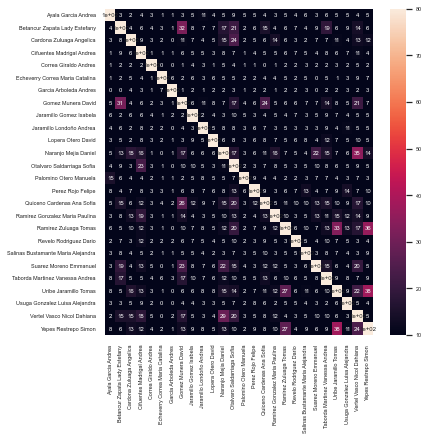

In [17]:
# print(df)
sns.set(font_scale=0.5)
figure = plt.gcf() # get current figure
figure.set_size_inches(6, 6)
mapa = sns.heatmap(df, annot=True, vmin = 10, vmax = 80)
plt.savefig(rootpath/'mapaSimilaridad.pdf', dpi=300,bbox_inches='tight')

### Crear un cuaderno con todos los códigos para comparación y verificación de fraudes

In [18]:
import os
for similar in mostSimilar:
    path1 = str(similar[0])
    path2 = str(similar[1])
    command = f'python pydiff.py -p "{path1}" "{path2}"'
    print(command)
    os.system(command)
# nb = nbf.v4.new_notebook()
# for (estPath,estName,estScripts) in zip(pathList,nameList,scriptList):
#     celdas = conformarCeldas(nb,estName,estScripts)
    
#     nb['cells'] += celdas
# nbf.write(nb, 'RevisionEntregas.ipynb')

### Refs

https://nbviewer.org/gist/fperez/9716279

https://github.com/yebrahim/pydiff